In [1]:
!pip install peft transformers datasets torch pandas scikit-learn
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [23]:
import pandas as pd
import re

def improved_preprocess(text):
    text = re.sub(r'[ㅋㅎ]{3,}', lambda m: m.group()[0]*2, text)
    text = re.sub(r'[ㅠㅜㅡ]{2,}', lambda m: m.group()[0]*2, text)
    text = re.sub(r'[^\w\s가-힣ㄱ-ㅎㅏ-ㅣ.,!?~]', '', text)
    return text.strip()

def labels_to_multihot(label_str, num_labels=9):
    label_list = [int(x) for x in str(label_str).split(',') if x.strip() != '']
    multihot = [0] * num_labels
    for l in label_list:
        if 0 <= l < num_labels:
            multihot[l] = 1
    return multihot

train_df = pd.read_csv('/content/drive/MyDrive/kmhas_train.txt', sep='\t', encoding='utf-8')
val_df = pd.read_csv('/content/drive/MyDrive/kmhas_valid.txt', sep='\t', encoding='utf-8')
test_df = pd.read_csv('/content/drive/MyDrive/kmhas_test.txt', sep='\t', encoding='utf-8')

print(len(train_df))
print(len(val_df))
print(len(test_df))
#데이터가 너무 많으면 샘플링 (예시: 2만개)
# train_df = train_df.sample(n=min(20000, len(train_df)), random_state=42)
# val_df = val_df.sample(n=min(20000, len(val_df)), random_state=42)
# test_df = test_df.sample(n=min(20000, len(test_df)), random_state=42)


for df in [train_df, val_df, test_df]:
    df['document'] = df['document'].apply(improved_preprocess)
    df['label_vec'] = df['label'].apply(labels_to_multihot)


78977
8776
21939


In [24]:
from transformers import AutoTokenizer
from torch.utils.data import Dataset

MODEL_NAME = "beomi/KcELECTRA-base-v2022"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})

class HateSpeechDataset(Dataset):
    def __init__(self, df, tokenizer, max_length=128):
        self.texts = df['document'].tolist()
        self.labels = df['label_vec'].tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        item = {key: val.squeeze(0) for key, val in encoding.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float)
        return item

train_dataset = HateSpeechDataset(train_df, tokenizer)
val_dataset = HateSpeechDataset(val_df, tokenizer)
test_dataset = HateSpeechDataset(test_df, tokenizer)


In [25]:
from transformers import AutoModelForSequenceClassification
from peft import LoraConfig, get_peft_model, TaskType
import torch

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=9,
    problem_type="multi_label_classification"
)
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["query", "key", "value", "dense"],
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.SEQ_CLS
)
model = get_peft_model(model, lora_config)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): ElectraForSequenceClassification(
      (electra): ElectraModel(
        (embeddings): ElectraEmbeddings(
          (word_embeddings): Embedding(54343, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): ElectraEncoder(
          (layer): ModuleList(
            (0-11): 12 x ElectraLayer(
              (attention): ElectraAttention(
                (self): ElectraSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): ModuleDict(
          

In [26]:
import torch.nn as nn
from transformers import TrainingArguments, Trainer
from sklearn.metrics import f1_score, accuracy_score

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.75, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
    def forward(self, inputs, targets):
        BCE_loss = nn.functional.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
        return focal_loss.mean()

focal_loss = FocalLoss()

def custom_loss(model, inputs):
    labels = inputs.pop("labels")
    outputs = model(**inputs)
    logits = outputs.logits
    loss = focal_loss(logits, labels)
    return (loss, outputs)

training_args = TrainingArguments(
    output_dir="./results_lora",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1",
    report_to=["none"]
)

def compute_metrics(pred):
    logits, labels = pred.predictions, pred.label_ids
    preds = (logits > 0).astype(int)
    f1 = f1_score(labels, preds, average="macro")
    acc = accuracy_score(labels, preds)
    return {"f1": f1, "labelwise_accuracy": acc}

from transformers import Trainer

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss = focal_loss(logits, labels)
        return (loss, outputs) if return_outputs else loss


trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)



In [27]:
trainer.train()
SAVE_DIR = "/content/drive/MyDrive/my_saved_model_lora_ver2"
model.save_pretrained(SAVE_DIR)
tokenizer.save_pretrained(SAVE_DIR)


Epoch,Training Loss,Validation Loss,F1,Labelwise Accuracy
1,0.020600,0.016021,0.763805,0.829421
2,0.015400,0.015541,0.799897,0.839562
3,0.012600,0.015006,0.807771,0.841272


('/content/drive/MyDrive/my_saved_model_lora_ver2/tokenizer_config.json',
 '/content/drive/MyDrive/my_saved_model_lora_ver2/special_tokens_map.json',
 '/content/drive/MyDrive/my_saved_model_lora_ver2/vocab.txt',
 '/content/drive/MyDrive/my_saved_model_lora_ver2/added_tokens.json',
 '/content/drive/MyDrive/my_saved_model_lora_ver2/tokenizer.json')

In [28]:
import numpy as np

def find_best_threshold(model, tokenizer, val_df):
    texts = val_df['document'].tolist()
    true_labels = np.array(val_df['label_vec'].tolist())
    all_probs = []
    for text in texts:
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=128)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = model(**inputs)
            probs = torch.sigmoid(outputs.logits).squeeze().cpu().numpy()
        all_probs.append(probs)
    all_probs = np.array(all_probs)
    best_threshold = 0.5
    best_f1 = 0
    for threshold in np.arange(0.1, 0.9, 0.02):
        preds = (all_probs >= threshold).astype(int)
        f1 = f1_score(true_labels, preds, average="macro")
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    print(f"최적 threshold: {best_threshold:.2f}, F1: {best_f1:.4f}")
    return best_threshold

best_threshold = find_best_threshold(model, tokenizer, val_df)


최적 threshold: 0.52, F1: 0.8105


In [15]:
## 저장된 모델 가져올 때

from peft import PeftModel, PeftConfig
from transformers import AutoModelForSequenceClassification, AutoTokenizer

SAVE_DIR = "/content/drive/MyDrive/my_saved_model_lora_ver2"
config = PeftConfig.from_pretrained(SAVE_DIR)
base_model = AutoModelForSequenceClassification.from_pretrained(config.base_model_name_or_path, num_labels=9)
model = PeftModel.from_pretrained(base_model, SAVE_DIR)
tokenizer = AutoTokenizer.from_pretrained(SAVE_DIR)
model.to(device)


LABEL_MAP = [
    "출신차별", "외모차별", "정치성향차별", "혐오욕설", "연령차별",
    "성차별", "인종차별", "종교차별", "해당사항없음"
]

#best_threshold를 찾았어
# 최적 threshold: 0.34, F1: 0.7443
def predict_labels(text, model, tokenizer, threshold=best_threshold):
    model.eval()
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.sigmoid(outputs.logits).squeeze().cpu().numpy()
    labels = [LABEL_MAP[i] for i, p in enumerate(probs) if p >= threshold]
    return labels, probs


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
from sklearn.metrics import f1_score, accuracy_score

exact_match_count = 0
at_least_one_match_count = 0
all_true = []
all_pred = []
n_samples = len(test_df)

for idx, row in test_df.iterrows():
    text = row['document']
    true_labels_vec = row['label_vec']
    true_labels_set = set([LABEL_MAP[i] for i, v in enumerate(true_labels_vec) if v == 1])
    pred_labels, pred_probs = predict_labels(text, model, tokenizer, threshold=best_threshold)
    pred_labels_set = set(pred_labels)
    if pred_labels_set == true_labels_set:
        exact_match_count += 1
    if len(pred_labels_set & true_labels_set) > 0:
        at_least_one_match_count += 1
    pred_vec = [1 if p >= best_threshold else 0 for p in pred_probs]
    all_true.append(true_labels_vec)
    all_pred.append(pred_vec)
    if (idx + 1) % (n_samples // 10) == 0:
        print(f"진행률: {(idx + 1) / n_samples * 100:.0f}% 완료")

import numpy as np
all_true = np.array(all_true)
all_pred = np.array(all_pred)
f1 = f1_score(all_true, all_pred, average="macro")
accuracy = (all_true == all_pred).all(axis=1).mean()
exact_match_ratio = exact_match_count / n_samples
at_least_one_match_ratio = at_least_one_match_count / n_samples
print(f"정확히 일치: {exact_match_ratio:.4f}")
print(f"하나라도 일치: {at_least_one_match_ratio:.4f}")
print(f"멀티라벨 Accuracy: {accuracy:.4f}")
print(f"Macro F1 score: {f1:.4f}")


진행률: 30% 완료
진행률: 50% 완료
진행률: 100% 완료
진행률: 70% 완료
진행률: 20% 완료
진행률: 80% 완료
진행률: 10% 완료
진행률: 90% 완료
진행률: 60% 완료
진행률: 40% 완료
정확히 일치: 0.6796
하나라도 일치: 0.9607
멀티라벨 Accuracy: 0.6796
Macro F1 score: 0.7375


In [ ]:
# 그냥 내가 입력하면서 결과 보고 싶을 때

In [16]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch

SAVE_DIR = "/content/drive/MyDrive/my_saved_model_lora_ver2"  # LoRA 모델 경로 (또는 기본 모델 경로)
model = AutoModelForSequenceClassification.from_pretrained(SAVE_DIR, num_labels=9)
tokenizer = AutoTokenizer.from_pretrained(SAVE_DIR)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(54343, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): lora.Linear(
                (base_layer): Linear(in_features=768, out_features=768, bias=True)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=768, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (defau

In [29]:
LABEL_MAP = [
    "출신차별", "외모차별", "정치성향차별", "혐오욕설", "연령차별",
    "성차별", "인종차별", "종교차별", "해당사항없음"
]

def predict_labels(text, model, tokenizer, threshold=0.4):
    model.eval()
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.sigmoid(outputs.logits).squeeze().cpu().numpy()
    labels = [LABEL_MAP[i] for i, p in enumerate(probs) if p >= threshold]
    return labels, probs


In [30]:
user_text = "무슨 남자가 통장인 줄 아냐. 이래서 여자는 안된다니까"
labels, probs = predict_labels(user_text, model, tokenizer, threshold=0.4)
print(f"입력 문장: {user_text}")
print(f"예측 라벨: {labels}")
print(f"라벨별 확률: {probs}")


입력 문장: 무슨 남자가 통장인 줄 아냐. 이래서 여자는 안된다니까
예측 라벨: ['성차별']
라벨별 확률: [0.17491043 0.06922614 0.05907229 0.15431549 0.11348992 0.80091846
 0.03581639 0.07592416 0.17095663]


최종 세트 3개 분석

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
# 필요한 라이브러리 설치 (필요시)
!pip install peft transformers datasets torch pandas scikit-learn matplotlib

In [35]:
import pandas as pd
import torch
import numpy as np
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# 데이터와 레이블 준비
test_df = pd.read_csv('/content/drive/MyDrive/kmhas_test.txt', sep='\t', encoding='utf-8')
test_inputs = test_df['document']# 원하는 만큼
test_labels = test_df['label']

def labels_to_multihot(label_str, num_labels=9):
    label_list = [int(x) for x in str(label_str).split(',') if x.strip() != '']
    multihot = [0] * num_labels
    for l in label_list:
        if 0 <= l < num_labels:
            multihot[l] = 1
    return multihot

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
threshold = 0.4
num_labels = 9
LABEL_MAP = [
    "출신차별", "외모차별", "정치성향차별", "혐오욕설", "연령차별",
    "성차별", "인종차별", "종교차별", "해당사항없음"
]

# 모델 경로와 불러오기 (1회)
models = {
    "Full Model": "/content/drive/MyDrive/my_saved_model",
    "LoRA Model": "/content/drive/MyDrive/my_saved_model_lora",
    "LoRA Model_ver2" : "/content/drive/MyDrive/my_saved_model_lora_ver2"
}

loaded_models = {}
loaded_tokenizers = {}
for name, path in models.items():
    model = AutoModelForSequenceClassification.from_pretrained(path, num_labels=num_labels)
    tokenizer = AutoTokenizer.from_pretrained(path)
    model.to(device)
    model.eval()
    loaded_models[name] = model
    loaded_tokenizers[name] = tokenizer


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [36]:
from sklearn.metrics import f1_score, accuracy_score
import numpy as np
import time

results = {name: [] for name in loaded_models}
exact_match = {name: 0 for name in loaded_models}
at_least_one = {name: 0 for name in loaded_models}
all_true_labels = {name: [] for name in loaded_models}
all_pred_labels = {name: [] for name in loaded_models}

total = len(test_inputs)

for name in loaded_models:
    model = loaded_models[name]
    tokenizer = loaded_tokenizers[name]

    for text, label_str in zip(test_inputs, test_labels):
        start = time.time()

        inputs = tokenizer(text, return_tensors="pt", truncation=True,
                           padding="max_length", max_length=128)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)
            probs = torch.sigmoid(outputs.logits).squeeze().cpu().numpy()
        end = time.time()
        results[name].append(end - start)

        true_vec = labels_to_multihot(label_str, num_labels=num_labels)
        pred_vec = [1 if p >= threshold else 0 for p in probs]

        all_true_labels[name].append(true_vec)
        all_pred_labels[name].append(pred_vec)

        if pred_vec == true_vec:
            exact_match[name] += 1
        if sum([tv * pv for tv, pv in zip(true_vec, pred_vec)]) > 0:
            at_least_one[name] += 1

    # F1 score 계산
    all_true_np = np.array(all_true_labels[name])
    all_pred_np = np.array(all_pred_labels[name])
    f1 = f1_score(all_true_np, all_pred_np, average='macro')

    print(f"[{name}]")
    print(f"Exact Match Accuracy: {exact_match[name]/total:.3f}")
    print(f"At-least-one Accuracy: {at_least_one[name]/total:.3f}")
    print(f"Macro F1 score: {f1:.3f}")
    print(f"Average inference time: {np.mean(results[name]):.4f} sec")
    print("-" * 40)


[Full Model]
Exact Match Accuracy: 0.831
At-least-one Accuracy: 0.910
Macro F1 score: 0.755
Average inference time: 0.0110 sec
----------------------------------------
[LoRA Model]
Exact Match Accuracy: 0.803
At-least-one Accuracy: 0.914
Macro F1 score: 0.741
Average inference time: 0.0234 sec
----------------------------------------
[LoRA Model_ver2]
Exact Match Accuracy: 0.780
At-least-one Accuracy: 0.952
Macro F1 score: 0.800
Average inference time: 0.0215 sec
----------------------------------------


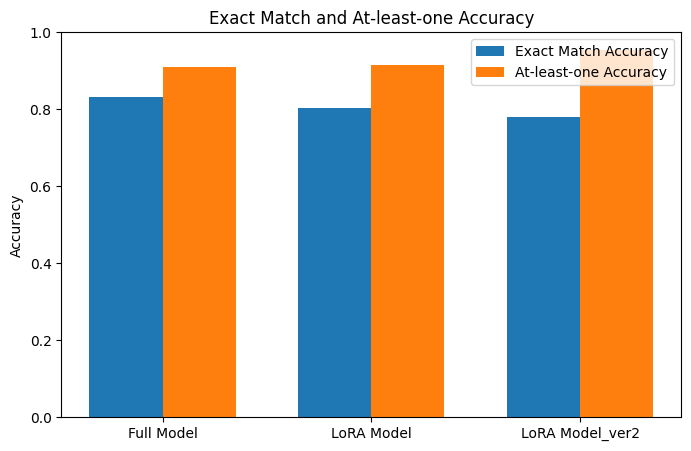

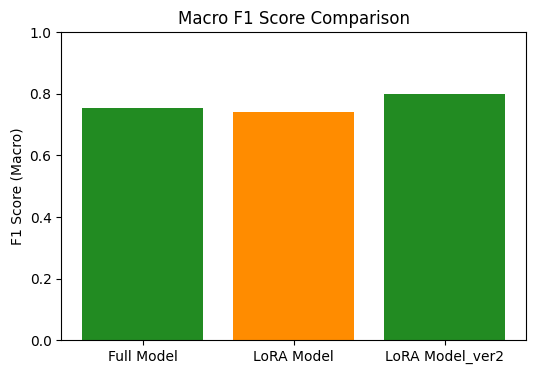

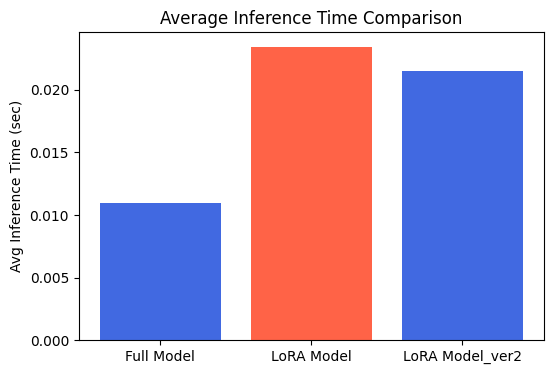

In [37]:
import matplotlib.pyplot as plt
import numpy as np

model_names = list(loaded_models.keys())

# 정확도 및 F1 점수 리스트 준비
exact_match_acc = [exact_match[name] / total for name in model_names]
at_least_one_acc = [at_least_one[name] / total for name in model_names]

all_true_np = {name: np.array(all_true_labels[name]) for name in model_names}
all_pred_np = {name: np.array(all_pred_labels[name]) for name in model_names}
f1_scores = [f1_score(all_true_np[name], all_pred_np[name], average='macro') for name in model_names]

# 평균 추론 시간 리스트 준비
avg_infer_time = [np.mean(results[name]) for name in model_names]

x = np.arange(len(model_names))
width = 0.35

# 정확도 비교 그래프
plt.figure(figsize=(8,5))
plt.bar(x - width/2, exact_match_acc, width, label='Exact Match Accuracy')
plt.bar(x + width/2, at_least_one_acc, width, label='At-least-one Accuracy')
plt.xticks(x, model_names)
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Exact Match and At-least-one Accuracy')
plt.legend()
plt.show()

# F1 score 비교 그래프
plt.figure(figsize=(6,4))
plt.bar(model_names, f1_scores, color=['forestgreen', 'darkorange'])
plt.ylim(0, 1)
plt.ylabel('F1 Score (Macro)')
plt.title('Macro F1 Score Comparison')
plt.show()

# 추론 시간 비교 그래프
plt.figure(figsize=(6,4))
plt.bar(model_names, avg_infer_time, color=['royalblue', 'tomato'])
plt.ylabel('Avg Inference Time (sec)')
plt.title('Average Inference Time Comparison')
plt.show()
